<h1 style="font-family:Impact,Arial;font-size:70px;">Statistical data analysis II</h1>
<h2 style="font-family:Arial;">Matias Quiroz</h2>
<p><small> School of Mathematical &amp; Physical Sciences<br>
University of Technology Sydney
</small></p>
<p>
<a href="mailto:matias.quiroz@uts.edu.au" target="_blank">
<small><font color=MediumVioletRed>matias.quiroz@uts.edu.au</font></small></a>
</p>
<hr style="height:5px;border:none;color:#333;background-color:#333;" />

<div style="background-color:#F2FBEF;">
<h2><font color=#04B404>After completing this notebook you should:</font></h2>
<br>
<ul>
<li> Have a basic understanding of how to fit simple regression and classification models in Python using packages. </li><br>
<li> Have a basic knowledge of how to implement the statistical methods underlying the packages yourself. </li><br>
</ul>
</div>


<hr style="height:5px;border:none;color:#333;background-color:#333;" />

# 1. Logistic regression without `scikit-learn`

In the regression examples in Notebook 10, the parameter estimates could be obtained in closed form using ordinary lease squares (OLS). This is not possible for the logistic regression model (and most other models) and one often needs to resort to numerical optimisation. This is what the function `LogisticRegression()` we used last week does under the hood and we now demonstrate how this can be implemented.

&nbsp;&nbsp;&nbsp;We first need to decide on an objective function to optimise. In the regression case, a suitable objective function was the error sum of squares

$$(\mathbf{y} - \mathbf{X}\boldsymbol{\beta})^\top (\mathbf{y} - \mathbf{X}\boldsymbol{\beta}),$$

however, this is not suitable for classification problems as $y$ is categorical. At first glance, it seems reasonable to minimise the misclassification rate 

$$\mathrm{MCR}(\boldsymbol{\beta}) = \frac{1}{n_{\mathrm{test}}}\sum_{i \in \mathcal{T}_{\mathrm{test}}} \mathbb{1}(y_i \neq \widehat{y}_i(\boldsymbol{\beta})),$$

where the dependence on $\boldsymbol{\beta}$ is emphasised. Optimising a function benefits greatly from using the gradient of the function and since the misclassification rate is discontinuous in $\boldsymbol{\beta}$, it is not a good choice since it is not differentiable. A common approach is to instead minimise the negative log-likelihood function (which is equivalent to maximise the positive log-likelihood function) which we now turn to. Intuitively, when maximising the log-likelihood, one finds the set of parameter values that are most plausible (in the sense that they give the highest likelihood) for the given sample.

The log-likelihood based on $\mathbf{y}=(y_1, \dots, y_n)^\top$ independent observations is 
$$\ell(\boldsymbol{\beta}|\mathbf{y}) = \sum_{i=1}^n \log p(y_i|\beta,\mathbf{x}_i). $$
The maximum likelihood estimator is defined as

\begin{align}
\widehat{\boldsymbol{\beta}} = \underset{\beta}{\operatorname{argmin}} -\ell(\boldsymbol{\beta}|\mathbf{y}),\label{neglikelihood} \tag{1}
\end{align}

and it can be shown that an approximate variance-covariance (useful for confidence intervals) matrix can be obtained as

$$\mathrm{Cov}(\widehat{\boldsymbol{\beta}}) = -\left( \nabla \nabla^\top \ell(\widehat{\boldsymbol{\beta}}|\mathbf{y}) \right)^{-1},$$

where $\nabla \nabla^\top \ell(\widehat{\boldsymbol{\beta}}|\mathbf{y})$ denotes the Hessian matrix evaluated at the likelihood mode $\widehat{\boldsymbol{\beta}}$

The optimisation in (1) can be carried out using built-in optimisers in `scipy` or by designing our own optimiser. We will start by demonstrating the first approach using the `minimize` function from the `scipy.optimize` module. This function also returns the inverse of the Hessian evaluated at the mode, which is useful for constructing approximate confidence intervals. We first need to simulate the data and split into train and test (as per the previous week) and, moreover, code the log-likelihood function of the model.

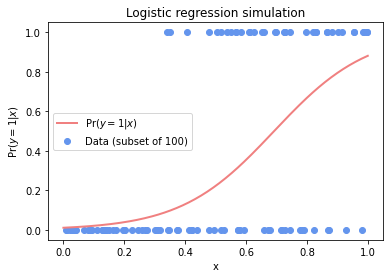

In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split


# Simulate 100 observations from a logistic regression model
np.random.seed(1234)
x = sps.uniform.rvs(size = 1000)  # y will be generated given these x values
beta0 = -4.5
beta1 = 6.5
z = beta0 + beta1*x 
y = sps.bernoulli.rvs(size = 1000, p = 1/(1 + np.exp(-z)))

# Plot a subset of the regression points (y is zero or one)
subset = np.random.choice(np.arange(1000), 100, replace = False)
plt.scatter(x[subset], y[subset], color = "cornflowerblue", label = "Data (subset of 100)")

# Plot the regression line (Pr(y = 1|x)) using a grid of x-values
x_grid = np.linspace(0, 1, 200)
z_grid =  beta0 + beta1*x_grid 

plt.plot(x_grid, 1/(1 + np.exp(-z_grid)), color = "lightcoral", linewidth=2, label = r'$\Pr(y = 1|x)$')

# Add labels and title
plt.xlabel("x")
plt.ylabel(r'$\Pr(y = 1|x)$')
plt.title("Logistic regression simulation")
plt.legend()

# Split into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [3]:
def log_likelihood_logistic(beta, y, X):
    """
    Log-likelihood for the logistic model.
    """
    z = np.dot(X, beta)
    log_Pr_y_1 = -np.log1p(np.exp(-z[y == 1])) # log Pr(y = 1)
    log_Pr_y_0 = -z[y == 0] - np.log1p(np.exp(-z[y == 0])) # log Pr(y = 0)
    
    return np.sum(log_Pr_y_1) + np.sum(log_Pr_y_0)

The following code estimates the parameters and performs prediction using the logistic regression model without the `LogisticRegression()` function. The code compares the results to those obtained using the `LogisticRegression()` function.

In [4]:
from sklearn.linear_model import LogisticRegression
X_train = np.vstack((np.ones(800), x_train)).T

# Estimating the model ourselves (without LogisticRgression())
neg_log_likelihood = lambda beta: -log_likelihood_logistic(beta, y_train, X_train)

beta_optim_start = np.zeros(2)
res_optim_likelihood = minimize(neg_log_likelihood, beta_optim_start, method='BFGS', jac = None, 
                                options={'gtol': 1e-04, 'maxiter': 1000, 'disp': True})

print(res_optim_likelihood)
# Standard errors for approximate confidence intervals.
standard_errors = np.sqrt(np.diag(res_optim_likelihood.hess_inv))
print('Estimates      : %s.' % res_optim_likelihood.x)
print('Standard errors: %s. ' % np.round(standard_errors, 3))

# Use LogisticRegression for comparison
model_logistic = LogisticRegression(penalty = None)
model_logistic.fit(x_train.reshape(-1, 1), y_train)


print('Estimated intercept')
print('LogisticRegression(): %3.3f. Our : %3.3f. True value: %3.3f' % (model_logistic.intercept_, res_optim_likelihood.x[0], beta0))
print('Estimated slope')
print('LogisticRegression(): %3.3f. Our : %3.3f. True value: %3.3f' % (model_logistic.coef_, res_optim_likelihood.x[1], beta1))

print('Predicting first 10 test observations')
print('LogisticRegression()')
print(model_logistic.predict_proba(x_test.reshape(-1, 1))[:10, :])
print('Without a package')
beta_hat = res_optim_likelihood.x
X_test = np.vstack((np.ones(200), x_test)).T
z = np.dot(X_test, beta_hat)
Pr_y_1_hat = 1/(1 + np.exp(-z))
Pr_y_0_hat = 1 - Pr_y_1_hat
print(np.vstack((Pr_y_0_hat, Pr_y_1_hat)).T[:10, :])

Optimization terminated successfully.
         Current function value: 316.011108
         Iterations: 12
         Function evaluations: 39
         Gradient evaluations: 13
      fun: 316.01110833735197
 hess_inv: array([[ 0.12006178, -0.16896971],
       [-0.16896971,  0.25846017]])
      jac: array([-7.62939453e-06, -7.62939453e-06])
  message: 'Optimization terminated successfully.'
     nfev: 39
      nit: 12
     njev: 13
   status: 0
  success: True
        x: array([-4.96727888,  7.19560121])
Estimates      : [-4.96727888  7.19560121].
Standard errors: [0.346 0.508]. 
Estimated intercept
LogisticRegression(): -4.967. Our : -4.967. True value: -4.500
Estimated slope
LogisticRegression(): 7.195. Our : 7.196. True value: 6.500
Predicting first 10 test observations
LogisticRegression()
[[0.49370842 0.50629158]
 [0.97654598 0.02345402]
 [0.09728647 0.90271353]
 [0.10596371 0.89403629]
 [0.48021172 0.51978828]
 [0.97508617 0.02491383]
 [0.98382906 0.01617094]
 [0.19546666 0.80453334]

The code above calls the function `minimize` to carry out the numerical optimisation. The function requires a starting value of the parameter vector (`beta_optim_start`), which method to use (`BFGS`, the Broyden–Fletcher–Goldfarb–Shanno method is an iterative method for unconstrained nonlinear optimisation), an optional gradient (`jac`, Jacobian, gradient of a vector valued function). The `options` attribute specifies the details of the optimisation: `gtol` specifies the tolerance level for the norm of the gradient to determine convergence (at the minimum $\widehat{\boldsymbol{\beta}}, \nabla_{\boldsymbol{\beta}}\ell(\widehat{\boldsymbol{\beta}}|\mathbf{y}) = \mathbf{0}$), while `maxiter` determines the maximum number of iterations and `disp` controls the display.

# 2. Improving the optimisation using gradient information
The optimisation above can be made more efficient by utilising the gradient of the objective function that can be supplied via the `jac` attribute. Without supplying a gradient, the optimiser computes the gradient by finite differences which can be computationally costly and inaccurate, especially if $\boldsymbol{\beta}$ is high-dimensional. An alternative is to code the gradient analytically ourselves. Even better (at least less tedious!) is to use automatic differentiation. The `autograd` package provides functions for computing the gradient and the Hessian using automatic differentiation.

In [4]:
!pip install autograd

Defaulting to user installation because normal site-packages is not writeable


<div style="background-color:#FBEFFB;"><p style="font-size:20px;color:#FF0080">&#9888; Beware!</p> <!--- Warning --->

<p>If the function we want to compute the gradient of contains any <code>numpy</code> or <code>scipy</code> functions, it is important that these come from autograd's version of <code>numpy</code> and <code>scipy</code>. See below for an illustration..</p> 

</div>

In [6]:
from autograd import grad, hessian # Automatic differentiation functions
import autograd.numpy as np_autograd # Important to use autograd's numpy and scipy if we want to take derivatives.

The following code shows that computing the gradient using automatic differentiation does not work if the function uses the standard `numpy` library.

In [7]:
grad_beta = grad(log_likelihood_logistic, 0) # The second argument indicates which argument we compute the gradient with respect to.
grad_beta(np.array([beta0, beta1]), y_train, X_train)

TypeError: loop of ufunc does not support argument 0 of type ArrayBox which has no callable exp method

The code below uses the `numpy` library from `autograd`.

In [8]:
def log_likelihood_logistic_autograd(beta, y, X):
    """
    Log-likelihood for the logistic model.
    """
    z = np_autograd.dot(X, beta)
    log_Pr_y_1 = -np_autograd.log1p(np_autograd.exp(-z[y == 1])) # log Pr(y = 1)
    log_Pr_y_0 = -z[y == 0] - np_autograd.log1p(np_autograd.exp(-z[y == 0])) # log Pr(y = 0)
    
    return np_autograd.sum(log_Pr_y_1) + np_autograd.sum(log_Pr_y_0)

# Try computing the gradient
grad_beta = grad(log_likelihood_logistic_autograd, 0) # The second argument indicates which argument we compute the gradient with respect to.
print(grad_beta(np.array([beta0, beta1]), y_train, X_train))

[-1.82643604  1.7372991 ]


The following code estimates the parameters by incorporating the gradient in the numerical optimisation. The optimisation is slightly more efficient compared to the one above that did not incorporate gradients and the differences will be more pronounced when there are more parameters. Finally, the code also computes asymptotically valid confidence intervals using (i) the `hess_inv` from `scipy.optimize` (as above) and (ii) using the automatic differentiation package. Note that none of these were possible using the `LogisticRegression()` function because the package does not provide standard errors. This is one example of when a package does not provide everything of interest and it is useful to be able to code it yourself.

In [9]:
neg_log_likelihood_autograd = lambda beta: -log_likelihood_logistic_autograd(beta, y_train, X_train)
grad_beta = grad(neg_log_likelihood_autograd)

beta_optim_start = np.zeros(2)
res_optim_likelihood = minimize(neg_log_likelihood_autograd, beta_optim_start, method='BFGS', jac = grad_beta, 
                                options={'gtol': 1e-04, 'maxiter': 1000, 'disp': True})

print(res_optim_likelihood)

print('Estimated intercept')
print('LogisticRegression(): %3.3f. Our : %3.3f. True value: %3.3f' % (model_logistic.intercept_, res_optim_likelihood.x[0], beta0))
print('Estimated slope')
print('LogisticRegression(): %3.3f. Our : %3.3f. True value: %3.3f' % (model_logistic.coef_, res_optim_likelihood.x[1], beta1))

print('Predicting first 10 test observations')
print('LogisticRegression()')
print(model_logistic.predict_proba(x_test.reshape(-1, 1))[:10, :])
print('Without a package')
beta_hat = res_optim_likelihood.x
X_test = np.vstack((np.ones(200), x_test)).T
z = np.dot(X_test, beta_hat)
Pr_y_1_hat = 1/(1 + np.exp(-z))
Pr_y_0_hat = 1 - Pr_y_1_hat
print(np.vstack((Pr_y_0_hat, Pr_y_1_hat)).T[:10, :])

# Finally, standard errors for approximate confidence intervals.
hess_beta = hessian(neg_log_likelihood_autograd)
standard_errors_autodiff = np.sqrt(np.diag(np.linalg.inv(hess_beta(res_optim_likelihood.x))))
print('Standard errors autodiff: %s. ' % np.round(standard_errors_autodiff, 3))
print('Standard errors scipy.optimize: %s. ' % np.round(standard_errors, 3))

print('Approximate 95% confidence intervals')
lower_CI = res_optim_likelihood.x - 1.96*standard_errors_autodiff
upper_CI = res_optim_likelihood.x + 1.96*standard_errors_autodiff
print(np.round(lower_CI, 3))
print(np.round(upper_CI, 3))

Optimization terminated successfully.
         Current function value: 316.011108
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
      fun: 316.01110833735123
 hess_inv: array([[ 0.12023962, -0.16922032],
       [-0.16922032,  0.25881259]])
      jac: array([-8.39198237e-06, -6.43864505e-06])
  message: 'Optimization terminated successfully.'
     nfev: 13
      nit: 12
     njev: 13
   status: 0
  success: True
        x: array([-4.96727905,  7.19560152])
Estimated intercept
LogisticRegression(): -4.967. Our : -4.967. True value: -4.500
Estimated slope
LogisticRegression(): 7.195. Our : 7.196. True value: 6.500
Predicting first 10 test observations
LogisticRegression()
[[0.49370842 0.50629158]
 [0.97654598 0.02345402]
 [0.09728647 0.90271353]
 [0.10596371 0.89403629]
 [0.48021172 0.51978828]
 [0.97508617 0.02491383]
 [0.98382906 0.01617094]
 [0.19546666 0.80453334]
 [0.21145111 0.78854889]
 [0.19294399 0.80705601]]
Without a package
[[0.493

# 3. Gradient-based optimisation without packages
Finally, we showcase how to do optimisation without packages using simple optimisation algorithms. As an illustrative example, we use a Poisson regression.

The Poisson regression model is $$p(y_i|\beta,x_i)= \frac{\mu_i^{y_i}\exp(-\mu_i)}{y_i!}, y_i \in \mathbb{Z}^+,$$
where $\mu_i = \exp(x_i^\top \beta) \geq 0$. Note that $\mathrm{E}(y_i|\beta,x_i)=\mu_i$. The following codes simulates and plots data from the model.

In [ ]:
n = 1000
true_params = np.array([2.5, 0.7])
X = np.hstack((np.ones((n, 1)), np.linspace(0, 3, n).reshape(-1, 1)))
y = sps.poisson.rvs(np.exp(np.dot(X, true_params))) # Model: y_i \sim Poisson(exp(beta_1*x_i1 + beta_2*x_i2)), first x_i1 = 1
plt.plot(X[:, 1], y, '.')

The log-likelihood based on $\mathbf{y}=(y_1, \dots, y_n)$ independent observations is 
$$\ell(\beta|\mathbf{y}) = \sum_{i=1}^n \log p(y_i|\beta,x_i) = \sum_{i=1}^n {y_i}\log(\mu_i)-\mu_i-\log(y_i!).$$
The following code implements the log-likelihood of the model. Note that the code uses `np_autograd` as imported above since we will compute the gradient using automatic differentiation.

In [ ]:
from scipy.special import factorial
def log_likelihood_function(beta, X, y):
    mu = np_autograd.exp(np_autograd.dot(X, beta))
    return(np_autograd.sum(y*np_autograd.log(mu) - mu - np_autograd.log(factorial(y))))

We obtain the MLE using gradient ascent. Starting from $\beta^{(0)}$, we iterate
$$\beta^{(j)} = \beta^{(j-1)} + \gamma \nabla \ell(\beta^{(j-1)}|\mathbf{y}) $$
where $\gamma > 0$ is the so-called learning rate, until some convergence criteria is met.


In [ ]:
# Compute gradient and Hessian by automatic differentiation:
grad_beta = grad(log_likelihood_function, 0)
Hess_beta = hessian(log_likelihood_function, 0)
# Gradient ascent method. Go in the direction of the gradient
beta_old = np.array([0, 0]) # Start value

gamma = 0.000001  # Learning rate
precision = 0.00001  # Desired precision of result
max_iters = 10000  # Maximum number of iterations
   
for i in range(max_iters):
    beta_new = beta_old + gamma * grad_beta(beta_old, X, y)
    step = beta_new - beta_old
    #print(beta_new)
    if np.linalg.norm(step) <= precision:
        break
    beta_old = beta_new

if i == (max_iters - 1):
    print("Careful as optimiser has not met termination criteria")
    print("Last iteration %s" % beta_new)
else:   
    print("Maximum achieved in %s iterations" % (i+1))   
    print("Maximum Likelihood Estimator", beta_new)
    print("Variance covariance matrix")
    print(-np.linalg.inv(Hess_beta(beta_new, X, y)))
    print("True parameters", true_params)

# 4. Second order optimisation without packages
It can be shown that if the learning rate mimics the local curvature (given by the Hessian) of the objective function, then the optimisation achieves optimal convergence rate. This happens when the learning rate is multiplied by $-\left(\nabla \nabla^\top \ell(\beta|y)\right)^{-1}$, in case this is known as Newton's method, or Newton-Raphson method. Such methods are referred to as second-order method. The gradient-based method in the previous section is referred to as first-order optimisation.

The following code implements Newton's method. It can be seen that it converges much faster than the above first order optimisation method

In [ ]:
# Alternative (faster) optimiser using Newton-Raphson. Adaptive (to the curvature of the function) step size multiplier
beta_old = np.zeros(2)
gamma = 1
precision = 0.00001  # Desired precision of result
max_iters = 10000  # Maximum number of iterations
   
for i in range(max_iters):
    beta_new = beta_old + gamma*np.linalg.solve(-Hess_beta(beta_old, X, y),  grad_beta(beta_old, X, y))
    step = beta_new - beta_old
    if np.linalg.norm(step) <= precision:
        break
    beta_old = beta_new

if i == (max_iters - 1):
    print("Careful as optimiser has not met termination criteria")
else:   
    print("Maximum achieved in %s iterations" % (i+1))   
    print("Maximum Likelihood Estimator", beta_new)
    print("Variance covariance matrix")
    print(-np.linalg.inv(Hess_beta(beta_new, X, y)))
    print("True parameters", true_params)

<div>
<br>
<br>
<br>
<hr style="height:5px;border:none;color:#333;background-color:#333;" />
<h1> Practice, Practice, Practice </h1>

<ol>
<li>Go through the notebook again and check that you have understood everything covered.</li><br>


<li> Do the tutorial problems that you can find on Canvas.</li><br>
</ol>
</div>


> Material by Matias Quiroz